<a href="https://colab.research.google.com/github/raultyv/Machine_learning/blob/main/Prediccion_Antawasi_rainfall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

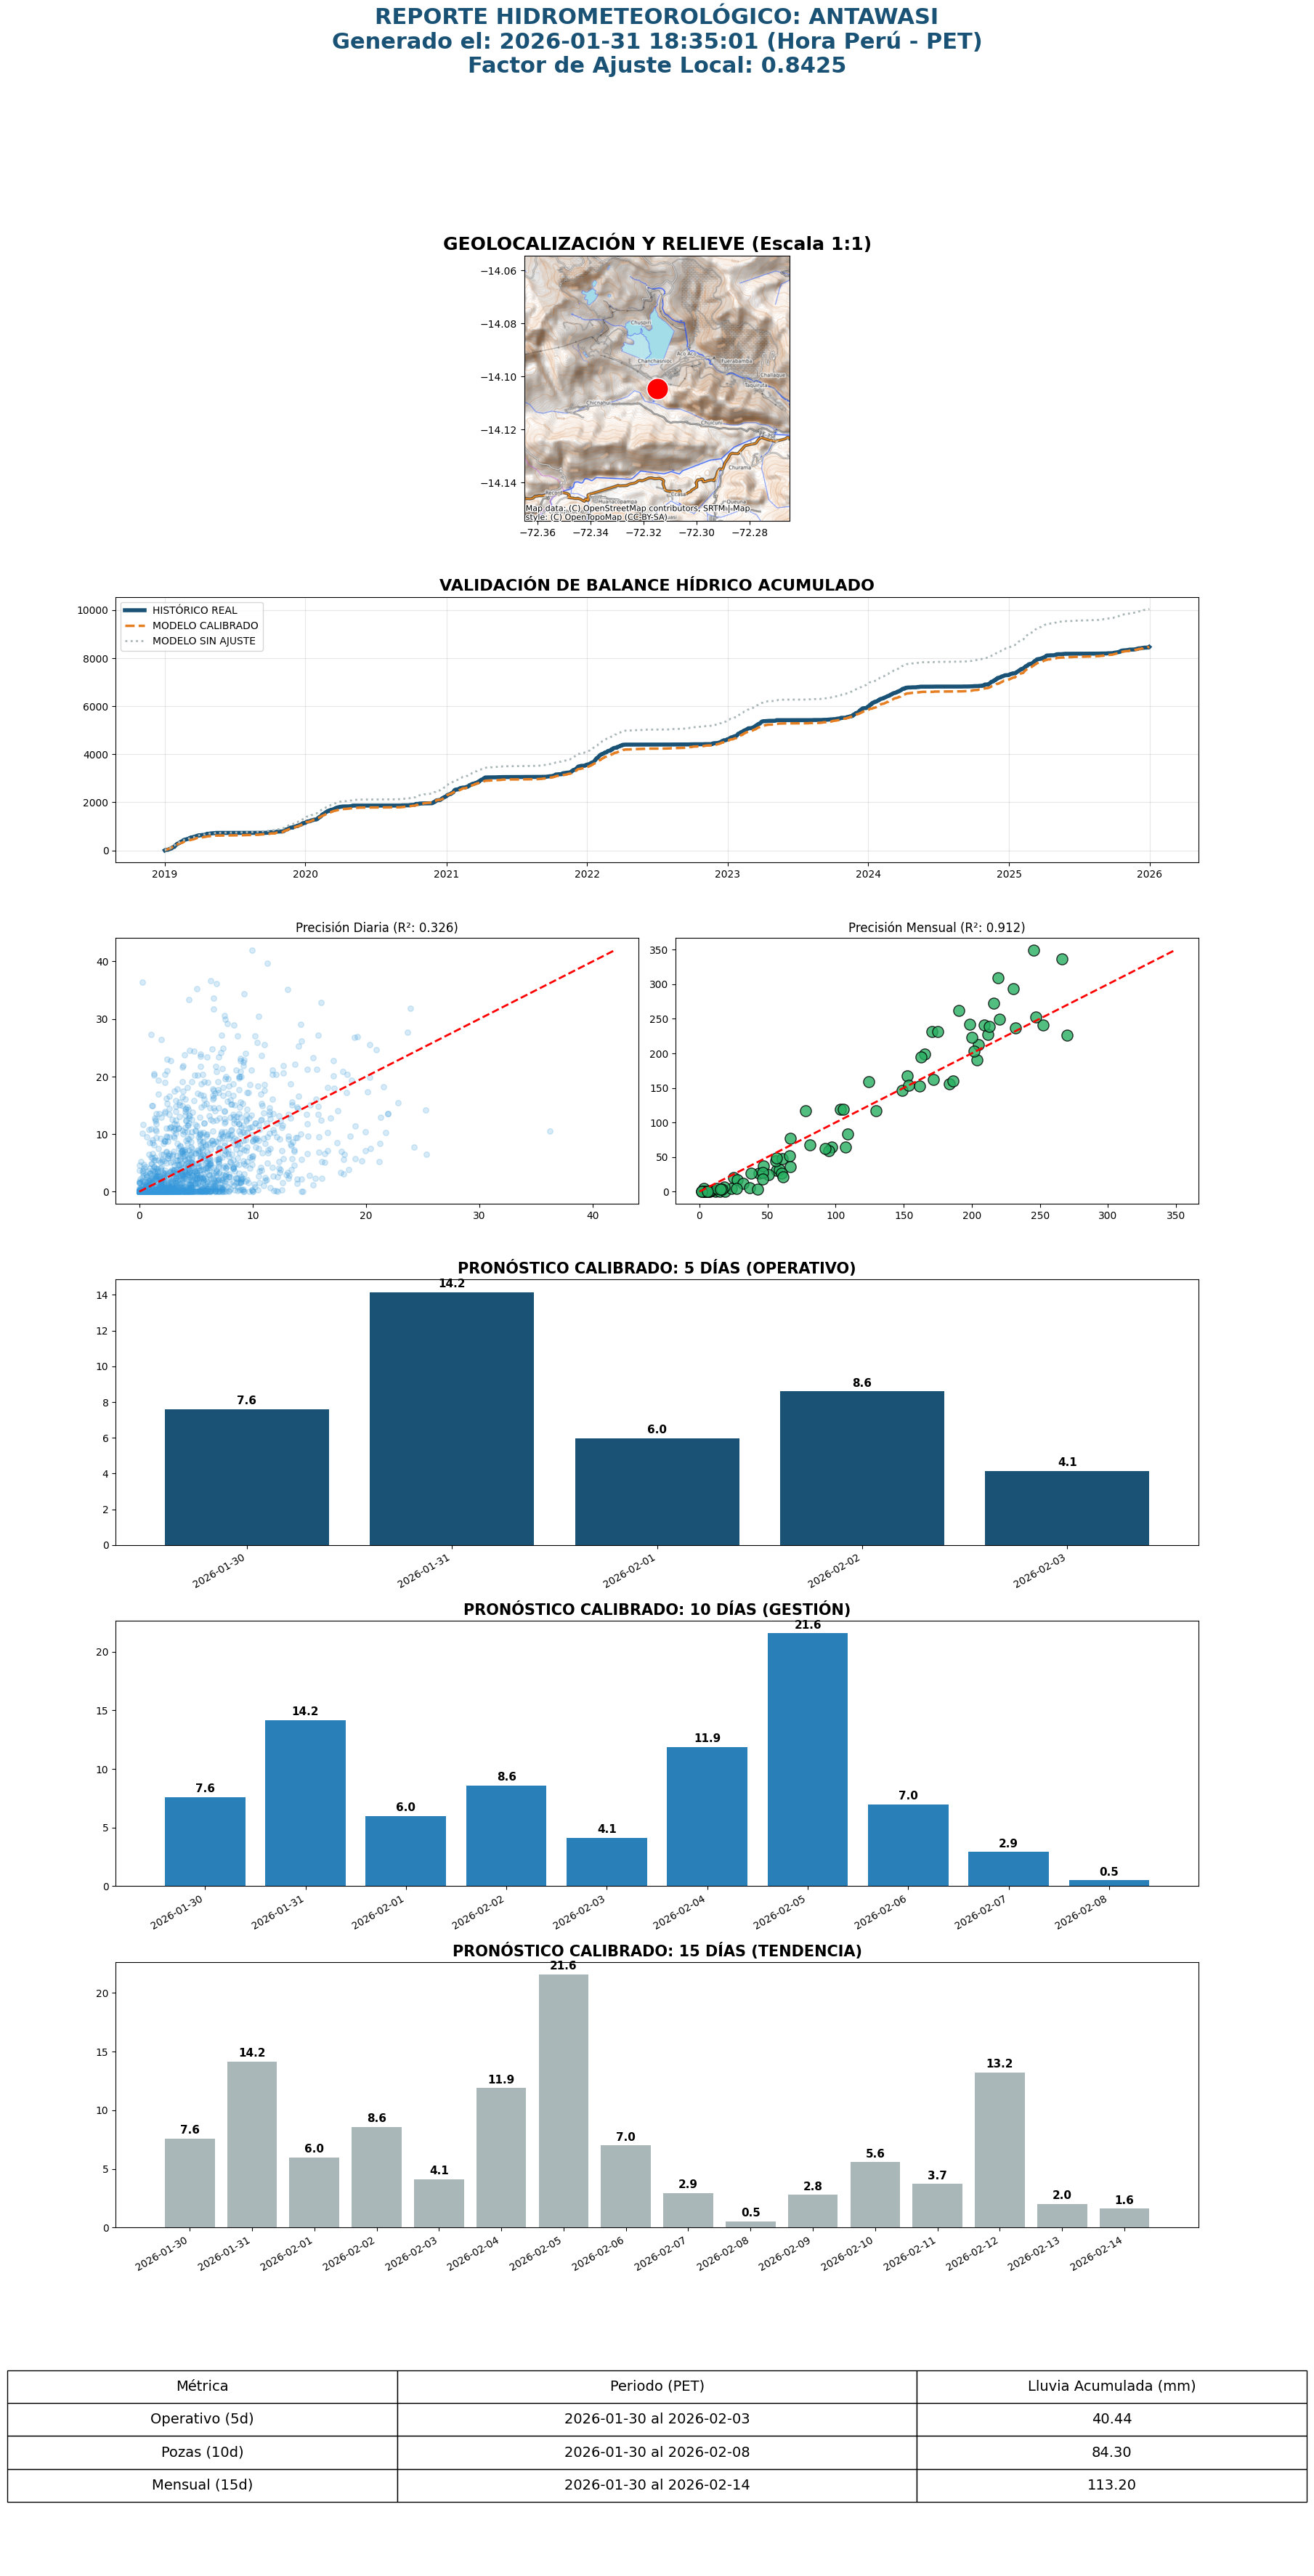

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
import contextily as cx
from sklearn.metrics import r2_score
from datetime import datetime
import pytz # Importante para la zona horaria

# --- CONFIGURACIÓN DE ZONA HORARIA PERÚ ---
tz_peru = pytz.timezone('America/Lima')
AHORA_PERU = datetime.now(tz_peru).strftime('%Y-%m-%d %H:%M:%S')

FILE_NAME = 'ANTAWASI.xlsx'
LAT, LON = -14.1045, -72.3149

def obtener_datos(lat, lon, inicio, fin, es_forecast=False):
    tipo = "forecast" if es_forecast else "archive"
    base_url = f"https://api.open-meteo.com/v1/{tipo}" if es_forecast else f"https://archive-api.open-meteo.com/v1/archive"

    # Forzamos a la API a responder en la zona horaria de Lima
    params = f"?latitude={lat}&longitude={lon}&hourly=precipitation&timezone=America%2FLima"
    if es_forecast: params += "&forecast_days=15"
    else: params += f"&start_date={inicio}&end_date={fin}"

    r = requests.get(base_url + params).json()
    df = pd.DataFrame({'f': pd.to_datetime(r['hourly']['time']), 'v': r['hourly']['precipitation']})

    # Sincronización con el cambio de guardia operativa de mina (07:00 AM)
    df['f_op'] = df['f'] - pd.Timedelta(hours=7)
    return df.groupby(df['f_op'].dt.date)['v'].sum()

try:
    # 1. CARGA Y CALIBRACIÓN
    df_ex = pd.read_excel(FILE_NAME, header=None, names=['fecha', 'valor'])
    df_ex['fecha'] = pd.to_datetime(df_ex['fecha']).dt.date
    estacion = df_ex.groupby('fecha')['valor'].sum()

    f_ini, f_fin = estacion.index.min().strftime('%Y-%m-%d'), estacion.index.max().strftime('%Y-%m-%d')
    modelo_raw = obtener_datos(LAT, LON, f_ini, f_fin)

    comp = pd.concat([estacion, modelo_raw], axis=1).dropna()
    comp.columns = ['Estacion', 'Modelo_Original']
    comp.index = pd.to_datetime(comp.index)

    factor_ajuste = comp['Estacion'].sum() / comp['Modelo_Original'].sum()
    comp['Modelo_Ajustado'] = comp['Modelo_Original'] * factor_ajuste
    comp_m = comp[['Estacion', 'Modelo_Ajustado']].resample('ME').sum()

    # 2. PRONÓSTICO (Sincronizado a hoy en Perú)
    pred_raw = obtener_datos(LAT, LON, None, None, es_forecast=True)
    pred_calib = pred_raw * factor_ajuste
    F_INICIO_PRED = pred_calib.index[0]

    # --- 3. PANEL DE CONTROL (HORA PERUANA) ---
    fig = plt.figure(figsize=(18, 62))
    gs = fig.add_gridspec(12, 2)

    # ENCABEZADO CON HORA DE PERÚ
    fig.suptitle(f"REPORTE HIDROMETEOROLÓGICO: ANTAWASI\nGenerado el: {AHORA_PERU} (Hora Perú - PET)\nFactor de Ajuste Local: {factor_ajuste:.4f}",
                 fontsize=22, fontweight='bold', y=0.98, color='#1a5276')

    # 3.1 MAPA 1:1
    ax0 = fig.add_subplot(gs[0, :])
    ax0.scatter([LON], [LAT], color='red', s=450, edgecolors='white', zorder=10)
    delta = 0.05
    ax0.set_xlim(LON - delta, LON + delta); ax0.set_ylim(LAT - delta, LAT + delta)
    ax0.set_aspect('equal')
    cx.add_basemap(ax0, crs='EPSG:4326', source=cx.providers.OpenTopoMap, zoom=13)
    ax0.set_title("GEOLOCALIZACIÓN Y RELIEVE (Escala 1:1)", fontsize=18, fontweight='bold')

    # 3.2 CURVA DE MASA
    ax1 = fig.add_subplot(gs[1, :])
    ax1.plot(comp.index, comp['Estacion'].cumsum(), label='HISTÓRICO REAL', color='#1a5276', lw=4)
    ax1.plot(comp.index, comp['Modelo_Ajustado'].cumsum(), label='MODELO CALIBRADO', color='#e67e22', ls='--', lw=2.5)
    ax1.plot(comp.index, comp['Modelo_Original'].cumsum(), label='MODELO SIN AJUSTE', color='#aab7b8', ls=':', lw=2)
    ax1.set_title('VALIDACIÓN DE BALANCE HÍDRICO ACUMULADO', fontsize=16, fontweight='bold')
    ax1.legend(loc='upper left'); ax1.grid(True, alpha=0.3)

    # 3.3 SCATTER PLOTS
    ax2 = fig.add_subplot(gs[2, 0])
    ax2.scatter(comp['Modelo_Ajustado'], comp['Estacion'], alpha=0.2, color='#3498db', s=30)
    max_val = max(comp['Estacion'].max(), comp['Modelo_Ajustado'].max())
    ax2.plot([0, max_val], [0, max_val], 'r--', lw=2)
    ax2.set_title(f'Precisión Diaria (R²: {r2_score(comp["Estacion"], comp["Modelo_Ajustado"]):.3f})')

    ax3 = fig.add_subplot(gs[2, 1])
    ax3.scatter(comp_m['Modelo_Ajustado'], comp_m['Estacion'], color='#27ae60', s=120, edgecolors='k', alpha=0.8)
    max_m = max(comp_m['Estacion'].max(), comp_m['Modelo_Ajustado'].max())
    ax3.plot([0, max_m], [0, max_m], 'r--', lw=2)
    ax3.set_title(f'Precisión Mensual (R²: {r2_score(comp_m["Estacion"], comp_m["Modelo_Ajustado"]):.3f})')

    # 3.4 PRONÓSTICOS
    def autolabel(ax, rects):
        for rect in rects:
            h = rect.get_height()
            if h > 0: ax.annotate(f'{h:.1f}', xy=(rect.get_x() + rect.get_width()/2, h),
                                  xytext=(0, 5), textcoords="offset points", ha='center', fontweight='bold', size=11)

    series = [(pred_calib.iloc[:5], '5 DÍAS (OPERATIVO)', '#1a5276'),
              (pred_calib.iloc[:10], '10 DÍAS (GESTIÓN)', '#2980b9'),
              (pred_calib, '15 DÍAS (TENDENCIA)', '#aab7b8')]

    for i, (data, tit, col) in enumerate(series):
        ax = fig.add_subplot(gs[3+i, :])
        bars = ax.bar(data.index.astype(str), data.values, color=col)
        ax.set_title(f'PRONÓSTICO CALIBRADO: {tit}', fontweight='bold', fontsize=15)
        autolabel(ax, bars)
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    # 3.5 TABLA DE RESUMEN OPERATIVO
    ax_t = fig.add_subplot(gs[6, :])
    ax_t.axis('off')
    resumen = [
        ['Métrica', 'Periodo (PET)', 'Lluvia Acumulada (mm)'],
        ['Operativo (5d)', f"{F_INICIO_PRED} al {pred_calib.index[4]}", f"{pred_calib.iloc[:5].sum():.2f}"],
        ['Pozas (10d)', f"{F_INICIO_PRED} al {pred_calib.index[9]}", f"{pred_calib.iloc[:10].sum():.2f}"],
        ['Mensual (15d)', f"{F_INICIO_PRED} al {pred_calib.index[-1]}", f"{pred_calib.sum():.2f}"]
    ]
    tabla = ax_t.table(cellText=resumen, loc='center', cellLoc='center', colWidths=[0.3, 0.4, 0.3])
    tabla.auto_set_font_size(False); tabla.set_fontsize(14); tabla.scale(1.2, 2.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except Exception as e:
    print(f"Error técnico detectado: {e}")